# Object oriented drawing script
So I was playing around and trying to teach myself object oriented programming. Although it is certainly not necessary to go through this for this purpose, it is a nice example to fall back on. This scripts contains: object oriented programming, classes, animation, matplotlib patches.

In [31]:
# Import packages at the top of the script
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
# Just for the notebook:
%matplotlib notebook

In [2]:
class turbine:
    ''' A horizontal axis wind turbine object '''

    def __init__(self,h=100,r=75,a=1):

        self.hubheight = h
        self.rotorradius = r
        self.rotorarea = 2*np.pi*r**2
        self.rot_status = 0 # Default rotation state
        self.view_angle = a # 1 = front, 2 = side

The above piece of code defines the turbine class. It doesn't create any turbines yet. The init function describes what to do when a turbine object is first created. It will set some parameters to certain values. For example, the hub height and and rotor radius can be specified, and the rotor area will be calculated. The rotation status and view angle will be explained later. Let's see how it works

In [3]:
myturbine = turbine()
myturbine.rotorarea

35342.917352885175

The first statement creates a wind turbine object with the default settings (hub height 100m, rotor 75m). The second comment prints the value of rotor area that is assigned to the object. Now, I'm going to add functions to draw the turbine, starting with the shaft. These function definitions are all still part of the turbine class, hence the indentation.

In [4]:
    def draw_shaft(self,width=10):
        ''' Draw the shaft of the wind turbine '''

        self.shaft_width = width
        points = [[-.5*width,0], #left bottom
                  [.5*width,0], # right bottom
                  [.25*width,self.hubheight], # right top
                  [-.25*width,self.hubheight] # left top
                 ]

        with plt.xkcd():
            shaft = plt.Polygon(points)

        return shaft

So, in the above code. I first define four points that constitute the shape of the shaft. It is wider at the bottom than at the top. Then, I use matplotlib to convert these points into a polygon object. This object is returned when the function is called. I used the xkcd style to give the drawing a 'sketchy' style. Likewise, I create the hub.

In [5]:
    def draw_hub(self):
        h = self.hubheight

        if self.view_angle == 1:
            points = [[-5,h-5],
                      [5,h-5],
                      [5,h+5],
                      [-5,h+5]
                     ]
        else: # self.view_angle == 2
            points = [[-5,h-5],
                      [15,h-5],
                      [15,h+5],
                      [-5,h+5]
                     ]

        with plt.xkcd():
            hub = plt.Polygon(points)

        return hub

Here, the view angle comes back. If the view angle parameter is set to 1, we will see the turbine up front and the hub will just be a square. If the view angle is set to 2, we will see a sort of side view in perspective. Then, the hub will be a rectangle that sticks out to the back more than to the front. Let's go on with the blades, and this is somewhat more tricky. I'll start with an hardcoded illustration.

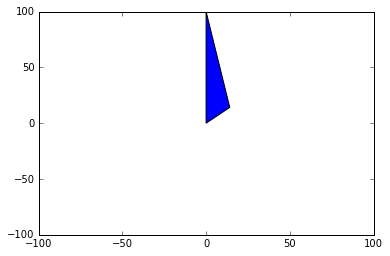

In [12]:
# Core of the blades function
theta = 0
r = 100
sec = .2*r
ang = 1/4.*np.pi
points = [[0.,0.], # blade root
          [r*np.sin(theta),r*np.cos(theta)], # blade tip
          [sec*np.sin(theta+ang),sec*np.cos(theta+ang)]] # blade shape
blade = plt.Polygon(points)

# Plot example
fig,ax = plt.subplots()
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.add_patch(blade)
plt.show()

Basically, the blades (in my conceptualized drawing) consist of three triangles. The first of the points is simply the blade root. The second point is the blade tip. The location (x,y) of this is given by the sine and cosine of the rotation angle, multiplied with the rotor radius. The third point is a bit arbitrarily chosed. I chose that the blade should broaden under a 45 degree (1/4 pi) angle up to a length of 20% of the turbine blade.

The full function for the blades is shown below:

In [13]:
    def draw_blades(self):
        ''' Draw the blades of the wind turbine '''

        # Some abbreviations
        width = self.shaft_width
        r = self.rotorradius
        theta = self.rot_status
        h = self.hubheight
        sec = 0.2*r # length of blade broadening section
        ang = 1/4.*np.pi # angle of blade broadening section

        if self.view_angle == 1:
            a = 1 # aspect angle
            o = 0 # offset
        else: # self.view_angle==2
            a = 0.2  # aspect angle
            o = -5 # offset

        # Blade angels for all three blades
        angles = self.rot_status+np.array([0,2/3.*np.pi,4/3.*np.pi])
        points = []
        for theta in angles:
            points.append([o+0.,h]) # blade root
            points.append([o+a*r*np.sin(theta),h+r*np.cos(theta)]) # blade tip
            points.append([o+a*sec*np.sin(theta+ang),h+sec*np.cos(theta+ang)]) # blade shape

        # Draw the blades
        with plt.xkcd():
            blades = plt.Polygon(points)

        return blades

Note that we still define the three points, but now we also do it for three different angles, so that we will get three wings in the end (although its still one polygon!). We have added the hub height to the y-coordinates, because we want the center of the blades to be at hub height. Furthermore, we have again used the viewing angle. If we look from it up front, everything is fine, be if we look under an angle from the side, we want the rotor disk to be elongated in the vertical. We achieve this by multiplying the x-coordinates by a factor smaller than 1. Also, we want the blades to have a little offset from the shaft. This is achieved by adding it to the x-coordinates as well. Finally, note that the rotation status is used to define the angles. This is necessary if we want to be able to rotate the blades later on.

Now that all parts have been defined, we can go on to put them together to construct the turbine:

In [14]:
    def draw(self,fig,pos=111):
        ''' Make a drawing of the wind turbine as an axis on given fig'''
        shaft = self.draw_shaft()
        hub = self.draw_hub()
        blades = self.draw_blades()

        with plt.xkcd():
            ax = fig.add_subplot(pos)
            ax.set_xlim(-100,100)
            ax.set_ylim(0,200)
            ax.set_axis_off()
            ax.add_patch(shaft)
            ax.add_patch(hub)
            ax.add_patch(blades)

        return ax,blades

This function takes input argument fig and pos, because I allways want to be able to draw on an existing figure. First, the previous three functions are called to obtain the polygon objects. Then, we create an axis, set the correct limits, and add the polygons to the plot. Now, we're ready to draw the turbine. However, I'm gonna wait a little longer with showing the result, and introduce one more function: to animate the plot.

In [15]:
    def animate(self,fig,blades):

        # Rotate changes the position of the blades
        def rotate(i):
            self.rot_status = -(i+1)*2*np.pi/300.
            newblades = self.draw_blades()
            xy = newblades.get_xy()
            blades.set_xy(xy)
            return blades,

        anim = animation.FuncAnimation(fig, rotate,
                                       frames=100,
                                       interval=20,
                                       blit=True)
        return anim

This function takes the figure and the blade object as input. Defined within is the `rotate` function. This function increments the rotation angle of the blades by a tiny amount. Then, it draws a new set of blades. The xy-coordinates of these blade points are extracted. Finally, the xy-points of the existing blades object are update to match the new coordinates, and the blades object is returned. 

The matplotlib FuncAnimation then calls the `rotate` function 100 times, so that the blades have turned exactly 1/3 of a circle, and are thus, optically, in their original arrangement, with one blade at the top.

The full object definition is shown below.

In [21]:
class turbine:
    ''' A horizontal axis wind turbine object '''

    def __init__(self,h=100,r=75,a=1):

        self.hubheight = h
        self.rotorradius = r
        self.rotorarea = 2*np.pi*r**2
        self.rot_status = 0 # Default rotation state
        self.view_angle = a # 1 = front, 2 = side

    def draw_shaft(self,width=10):
        ''' Draw the shaft of the wind turbine '''

        self.shaft_width = width
        points = [[-.5*width,0], #left bottom
                  [.5*width,0], # right bottom
                  [.25*width,self.hubheight], # right top
                  [-.25*width,self.hubheight] # left top
                 ]

        with plt.xkcd():
            shaft = plt.Polygon(points)

        return shaft

    def draw_hub(self):
        h = self.hubheight

        if self.view_angle == 1:
            points = [[-5,h-5],
                      [5,h-5],
                      [5,h+5],
                      [-5,h+5]
                     ]
        else: # self.view_angle == 2
            points = [[-5,h-5],
                      [15,h-5],
                      [15,h+5],
                      [-5,h+5]
                     ]

        with plt.xkcd():
            hub = plt.Polygon(points)

        return hub

    def draw_blades(self):
        ''' Draw the blades of the wind turbine '''

        # Some abbreviations
        width = self.shaft_width
        r = self.rotorradius
        theta = self.rot_status
        h = self.hubheight
        sec = 0.2*r # length of blade broadening section
        ang = 1/4.*np.pi # angle of blade broadening section

        if self.view_angle == 1:
            a = 1 # aspect angle
            o = 0 # offset
        else: # self.view_angle==2
            a = 0.2  # aspect angle
            o = -5 # offset

        # Blade angels for all three blades
        angles = self.rot_status+np.array([0,2/3.*np.pi,4/3.*np.pi])
        points = []
        for theta in angles:
            points.append([o+0.,h]) # blade root
            points.append([o+a*r*np.sin(theta),h+r*np.cos(theta)]) # blade tip
            points.append([o+a*sec*np.sin(theta+ang),h+sec*np.cos(theta+ang)]) # blade shape

        # Draw the blades
        with plt.xkcd():
            blades = plt.Polygon(points)

        return blades

    def draw(self,fig,pos=111):
        ''' Make a drawing of the wind turbine as an axis on given fig'''
        shaft = self.draw_shaft()
        hub = self.draw_hub()
        blades = self.draw_blades()

        with plt.xkcd():
            ax = fig.add_subplot(pos)
            ax.set_xlim(-100,100)
            ax.set_ylim(0,200)
            ax.set_axis_off()
            ax.add_patch(shaft)
            ax.add_patch(hub)
            ax.add_patch(blades)

        return ax,blades

    def animate(self,fig,blades):

        # Rotate changes the position of the blades
        def rotate(i):
            self.rot_status = -(i+1)*2*np.pi/300.
            newblades = self.draw_blades()
            xy = newblades.get_xy()
            blades.set_xy(xy)
            return blades,

        anim = animation.FuncAnimation(fig, rotate,
                                       frames=100,
                                       interval=20,
                                       blit=True)
        return anim

### How it works

<IPython.core.display.Javascript object>


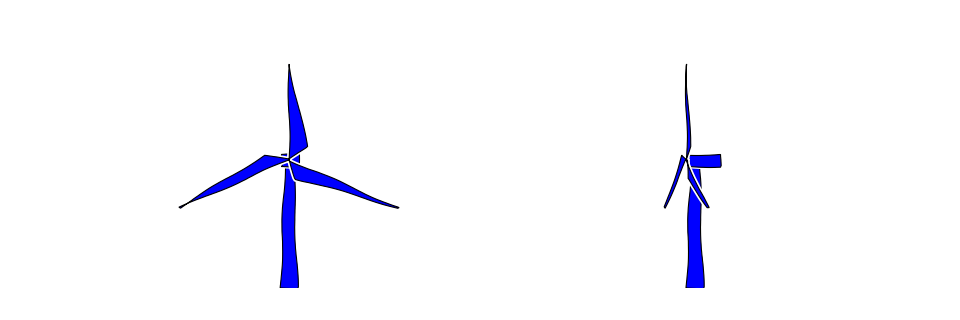

In [33]:
myturbine = turbine()
myturbine2 = turbine(a=2)

fig = plt.figure(figsize=(12,4))
ax,blades = myturbine.draw(fig,121)
ax2,blades2 = myturbine2.draw(fig,122)

In [40]:
# Initialise turbine object
mill = turbine(a=2)

# Make a figure
fig = plt.figure()
ax,blades = mill.draw(fig,111)
    
anim = mill.animate(fig,blades)

# This is for it to work in notebooks:
from IPython.display import HTML
HTML(anim.to_html5_video())

# Instead, this would  work in normal (I)Python
#plt.show()

# And this is to save as video
# anim.save('turbine.mp4', fps=30,
#       extra_args=['-vcodec', 'h264',
#                   '-pix_fmt', 'yuv420p'])